## This notebook is meant to demonstrate how to use the `ClimbingDataset` class  

You can use it as a starting point for developing your CNN models.


In [8]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# Project modules
from utils import *
from utils_visualisation import *
from Data_Handler import ClimbingDataset

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


# Image filters
import kornia.filters as KF




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
transform = KF.GaussianBlur2d(kernel_size=(3, 3), sigma=(1.0, 1.0), border_type="constant")

climbing_DB = ClimbingDataset(board_names=["12 x 12 with kickboard Square", "8 x 12 Home"],
                            map=True, 
                            transform=transform,
                            label_filter=[5, 14],
                            max_samples=5000 
)



5000
torch.Size([1, 4, 35, 35]) torch.Size([21])


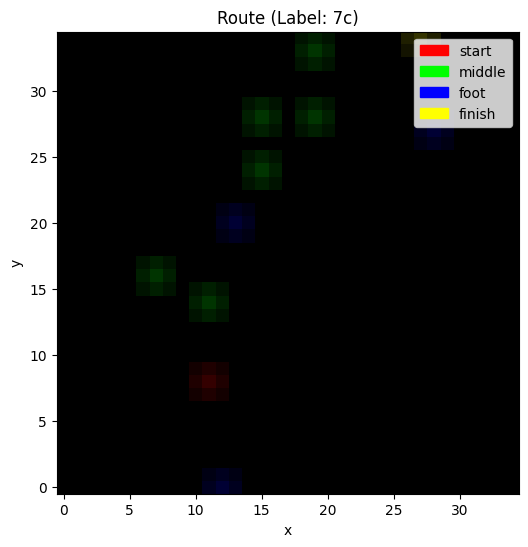

In [10]:
print(len(climbing_DB))

X, y = climbing_DB[15]

print(X.shape, y.shape)
plot_route(X, torch.argmax(y))



In [11]:

train_size = int(0.8 * len(climbing_DB))  # 80% train
test_size = len(climbing_DB) - train_size

# Deterministic split (set generator seed for reproducibility)
train_dataset, test_dataset = random_split(
    climbing_DB,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

total_bytes = 0
for data, target in train_dataset:
    if isinstance(data, torch.Tensor):
        total_bytes += data.element_size() * data.nelement()
    if isinstance(target, torch.Tensor):
        total_bytes += target.element_size() * target.nelement()
        
for data, target in test_dataset:
    if isinstance(data, torch.Tensor):
        total_bytes += data.element_size() * data.nelement()
    if isinstance(target, torch.Tensor):
        total_bytes += target.element_size() * target.nelement()

print("Approx dataset tensor size:", total_bytes / 1e6, "MB")



Train samples: 4000, Test samples: 1000
Approx dataset tensor size: 98.42 MB


In [12]:
print(measure_loader_time(train_loader, num_batches=200))

/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Average batch load time: 3.53 ms over 124 batches
3.5318013144807345


Hold statistics per difficulty:

Class 6a+:
  Avg total holds: 13.44
  Avg role composition: start=1.83, middle=5.37, foot=5.06, finish=1.19

Class 7c:
  Avg total holds: 11.17
  Avg role composition: start=1.69, middle=4.66, foot=3.78, finish=1.04

Train distribution:
  Class 6a+: 1844.0 (46.1%)
  Class 7c: 2156.0 (53.9%)

Test distribution:
  Class 6a+: 431.0 (43.1%)
  Class 7c: 569.0 (56.9%)


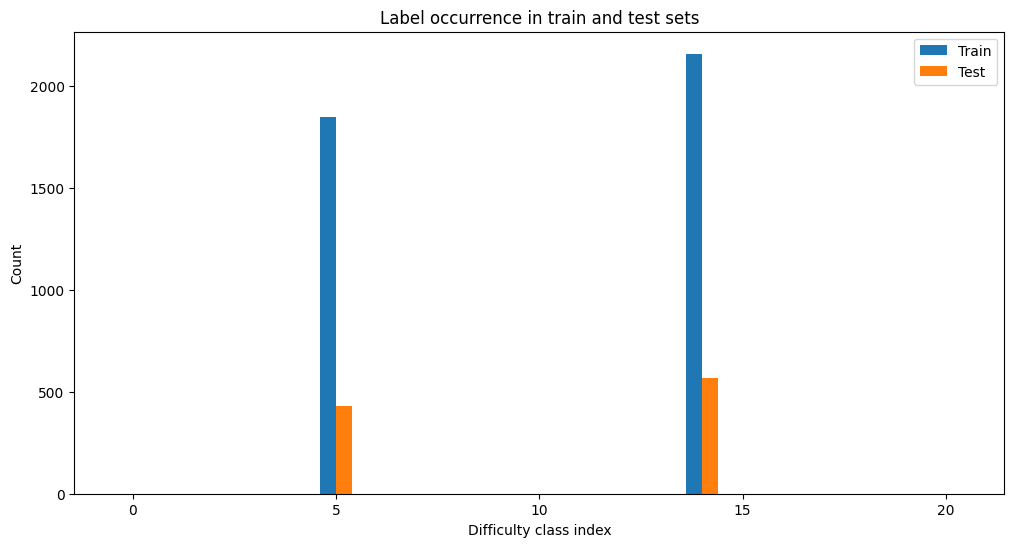

In [13]:

print_hold_statistics(train_dataset, num_classes=climbing_DB.num_classes )

    
plot_label_distribution(train_dataset, test_dataset, num_classes=climbing_DB.num_classes)




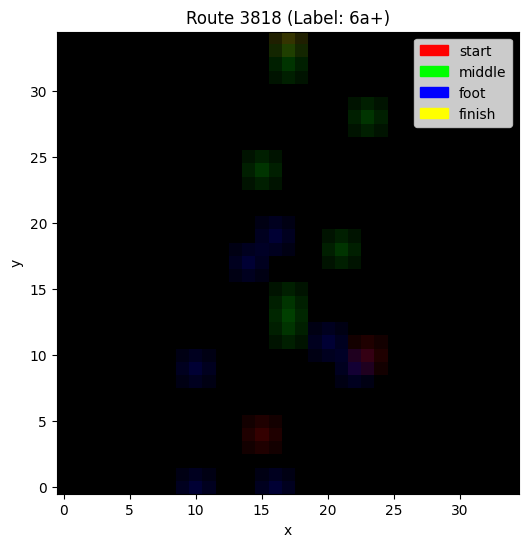

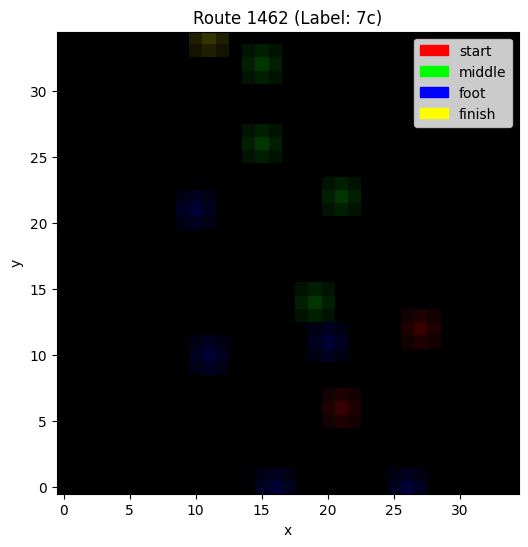

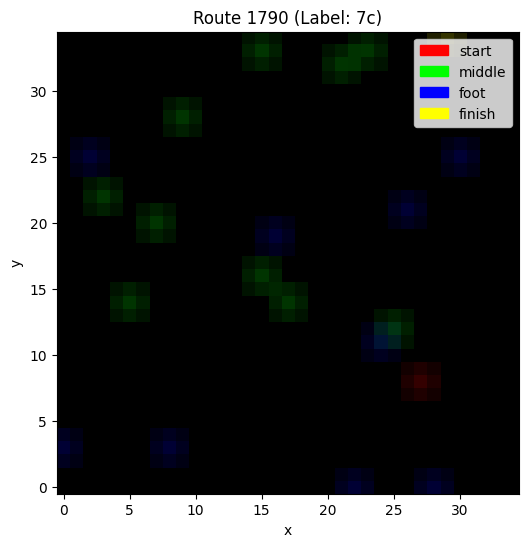

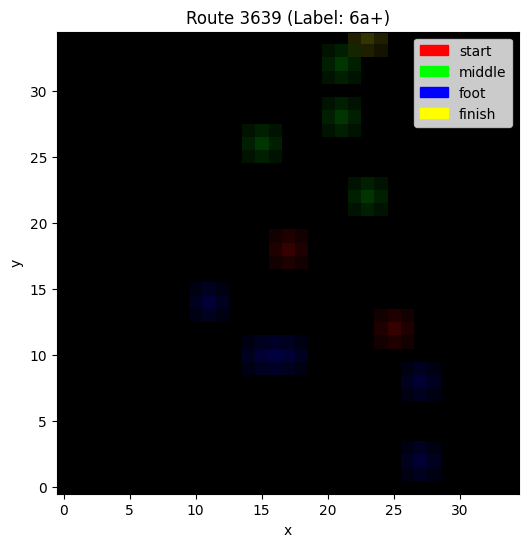

In [16]:
plot_sample_routes(train_dataset, n=4, grades=[f"V{i}" for i in range(climbing_DB.num_classes)])
